## Arnoldi method

The Arnoldi method is an extension on the power method. For a matrix in $\mathbb{R}^{n, n}$, it computes a set of $k$ largest eigenvalues

It improves on the power method in the following ways:

1. it computes multiple eigenpairs at once
2. it builds an orthonormal basis $Q$ of the Krylov space $\text{span}\{x, Ax, A^2x, \ldots, A^{k-1}x\}$.
3. it builds a partial Hessenberg decomposition of $A$

### Properties

In practice, it iteratively builds the Arnoldi decomposition. For iteration $m$, this is $$AQ = QH + h_{m+1,m}q_{m+1}e_m^T$$

where $e_m$ is the m-th unit vector in $\mathbb{R}^n$.

This decomposition has the following properties:

1. It projects $A$ onto the Krylov subspace: $Q^T AQ = \bar{H}$ ($m \times m$ matrix, $\bar{H}$ is $H$ without its last row)
2. It compute ritz pairs: if $(\theta, y)$ is an eigenpair of $\bar{H}$, then $(\theta, Qy)$ is an approximate eigenpair of $A$.
3. Residuals can be computed to check convergence. For an approximate eigenpair $(\theta, x = Qy)$: $r = Ax - \theta x = (AQ - Q\bar{H})y = h_{m+1,m}(e_m^T y)q_{m+1}$

In [1]:
import os.path as op

import numpy as np
from scipy.io import loadmat
from scipy.linalg import eig, eigvals, qr
from scipy.sparse.linalg import eigs as s_eigs

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

In [2]:
def load_data(name):
    d = loadmat(f"{name}.mat")
    A = d["Problem"][0][0][1]
    d = loadmat(f"{name}_SVD.mat")
    v = d["S"][0][0][0]

    return A, v[:, 0]

# From the suite sparse matrix collection
A, A_v_ref = load_data(op.join("data", "1138_bus"))

In [3]:
def arnoldi(A, q, m, tol=1e-7):
    """ Arnoldi methods for square matrix A.

    Parameters
    ----------
    A: 2d n x n array
    q: initial 1d n array (generally randomly generated)
    m: integer
    """
    # This simple arnoldi implementation builds 
    # 1. an orthonormal basis Q of the Krylov space for A
    # 2. an Hessenberg transform of A
    assert A.ndim == 2
    assert v.ndim == 1
    assert A.shape[0] == A.shape[1], "A is not square"

    n = A.shape[0]
    # Q is the orthonormal basis of A's Krylov space
    Q = np.zeros((n, m+1), A.dtype)
    # H will be the Hessenberg matrix
    H = np.zeros((m+1, m), A.dtype)

    Q[:, 0] = q / np.linalg.norm(q)

    for j in range(m):
        w = A @ Q[:, j]
        for i in range(j):
            H[i, j] = Q[:, i] @ w
            # Orthogonalization step
            w = w - H[i, j] * Q[:, i]

        H[j+1, j] = np.linalg.norm(w)
        if np.abs(H[j+1, j]) < tol:
            print(f"Lucky breakdown @ {j}!")
            return Q[:, :j+1], H[:j+1, :j+1]

        Q[:, j+1] = w / H[j+1, j]

    return Q[:, :m], H[:m, :]

def compute_residuals(A, Q, H, m):
    eigenvalues, eigenvectors = np.linalg.eig(H)
    residuals = np.zeros(m, dtype=A.dtype)
    for i, (λ, v) in enumerate(zip(eigenvalues[:m], eigenvectors[:, :m].T)):
        Qv = Q @ v
        r = A @ Qv - λ * Qv
        residuals[i] = np.linalg.norm(r)

    return residuals

In [4]:
n_iter = 100
n_eigs = 10
v = np.random.randn(A.shape[0])
V, H = arnoldi(A, v, n_iter)
A_v_arpack = s_eigs(A, n_eigs)[0]

residuals = compute_residuals(A, V, H, n_iter)

ref = A_v_ref[:n_eigs]

# Hack to make eigenvalues comparable. Reference and "proper" eigensolvers will
# give the eigenvalues in (decreasing) sorted order
A_v = eigvals(H)
idx = np.argsort(A_v)[::-1]
A_v_arnoldi = A_v[idx][:n_eigs]
residuals = residuals[idx]

for j in range(n_eigs):
    print(f"diff arnoldi vs ref:         {np.linalg.norm(A_v_arnoldi[j] - ref[j])}")
for j in range(n_eigs):
    print(f"residual {j} is:               {residuals[j]}")

diff arnoldi vs ref:         9.458744898438454e-11
diff arnoldi vs ref:         6.548361852765083e-11
diff arnoldi vs ref:         1.0913936421275139e-11
diff arnoldi vs ref:         1.4551915228366852e-11
diff arnoldi vs ref:         4.729372449219227e-11
diff arnoldi vs ref:         7.98536348156631e-09
diff arnoldi vs ref:         3.147943061776459e-08
diff arnoldi vs ref:         2.6619090931490064e-08
diff arnoldi vs ref:         1.2198142940178514e-08
diff arnoldi vs ref:         4.663888830691576e-09
residual 0 is:               7.532777878085502e-11
residual 1 is:               1.184603519119576e-10
residual 2 is:               1.3455710378564437e-10
residual 3 is:               7.49631006832043e-11
residual 4 is:               2.2588061391727918e-10
residual 5 is:               6.231230528793731e-05
residual 6 is:               4.9728607604615576e-05
residual 7 is:               0.00012367143461051815
residual 8 is:               2.7192393442780596e-05
residual 9 is:          

Text(0.5, 1.0, 'Residuals')

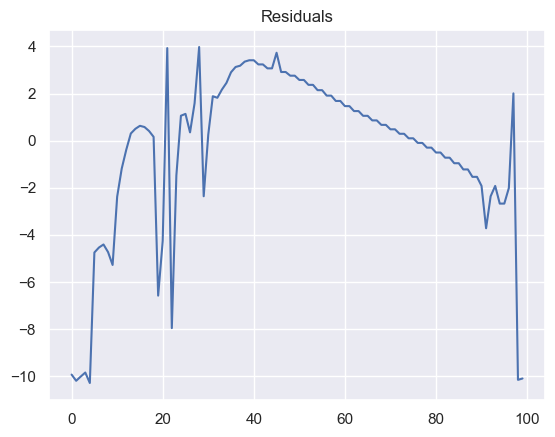

In [7]:
plt.plot(np.log10(residuals))
plt.title("Residuals")

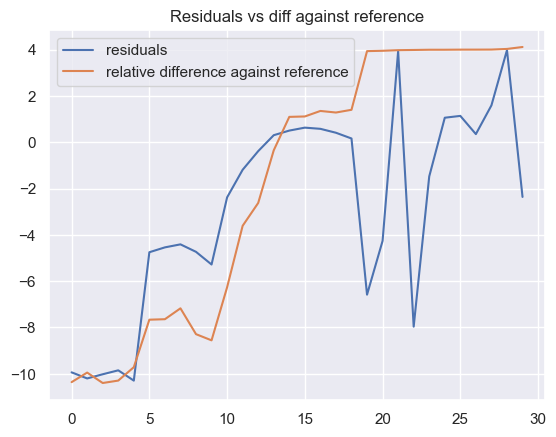

In [8]:
ref_diff = np.array([np.linalg.norm(A_v_arnoldi[j] - ref[j]) for j in range(n_eigs)])
plt.plot(np.log10(residuals[:n_eigs]), label="residuals")
plt.plot(np.log10(ref_diff), label="relative difference against reference")
plt.title("Residuals vs diff against reference")
plt.legend()